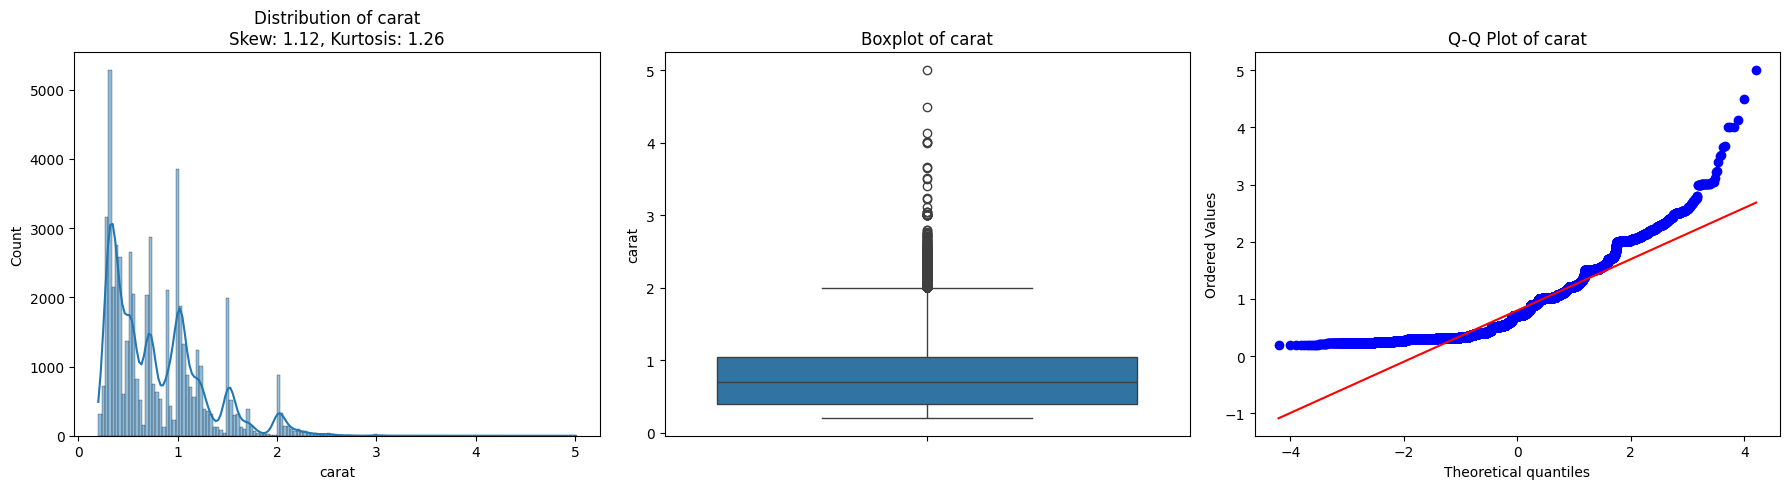

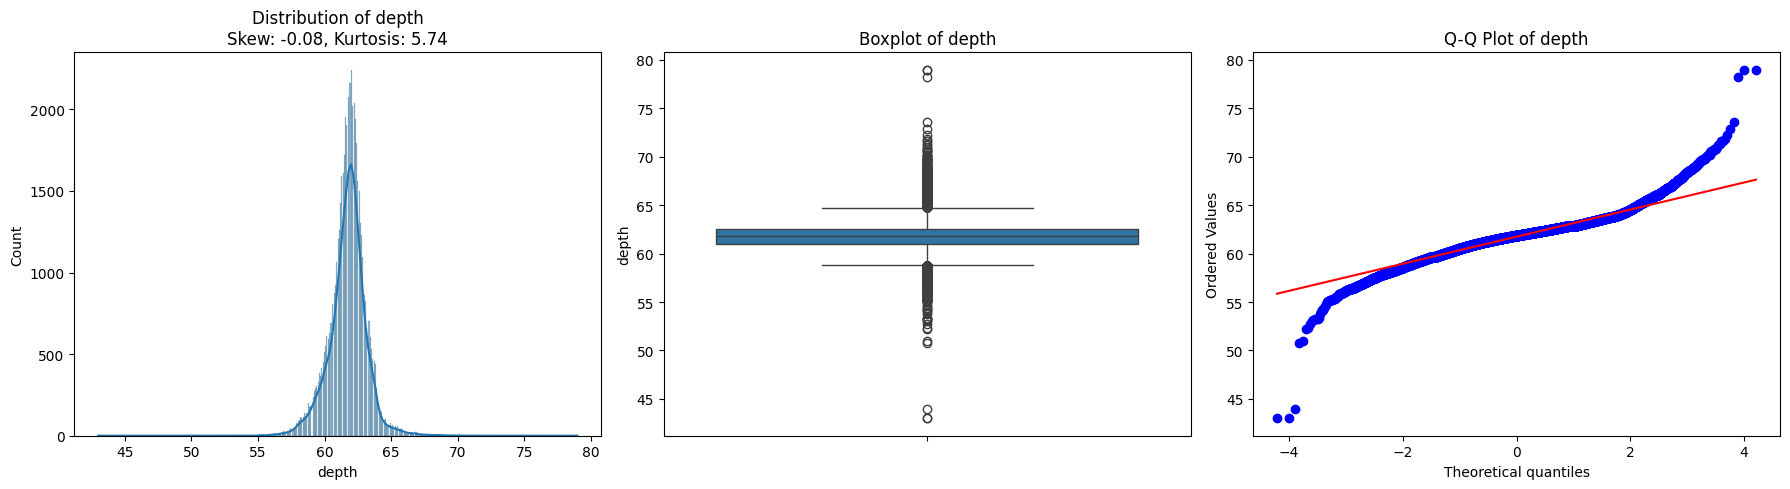

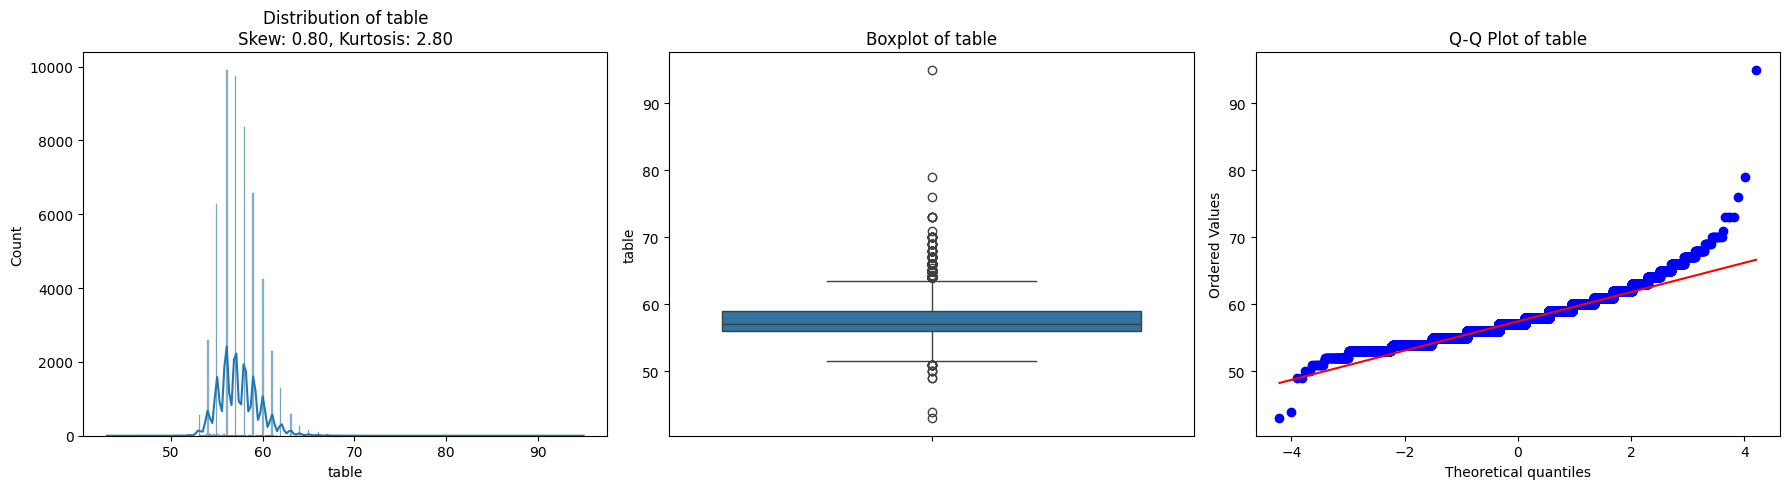

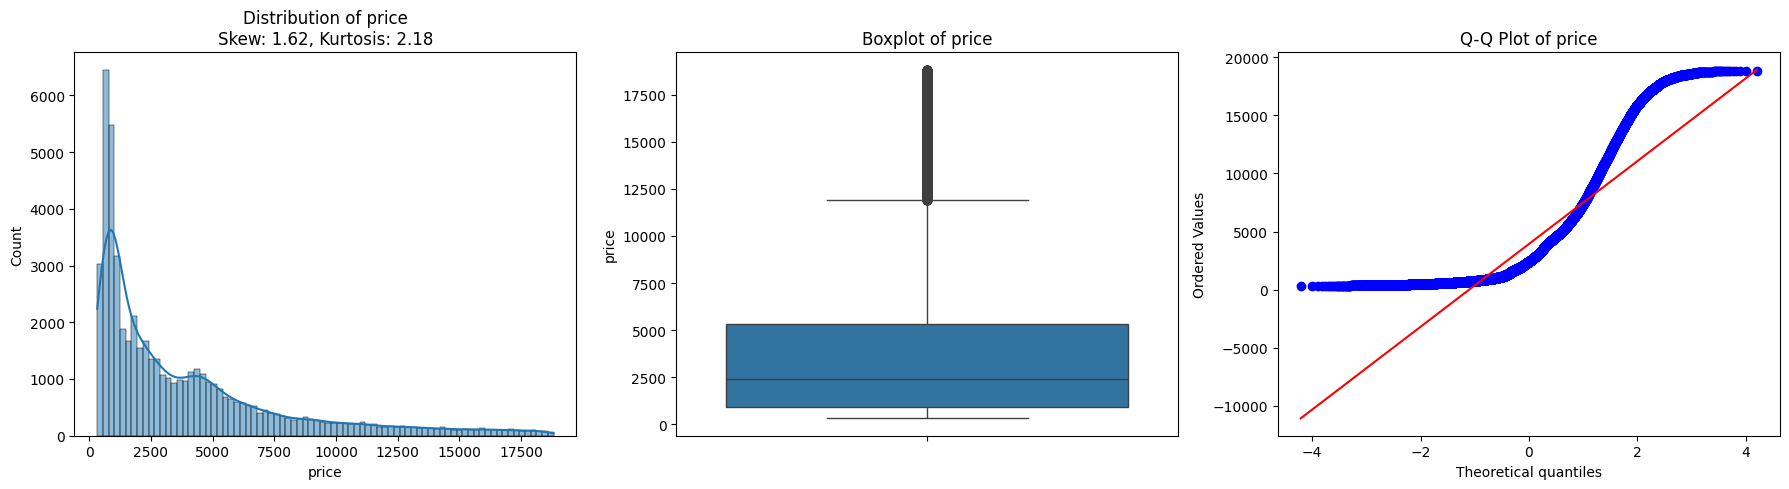

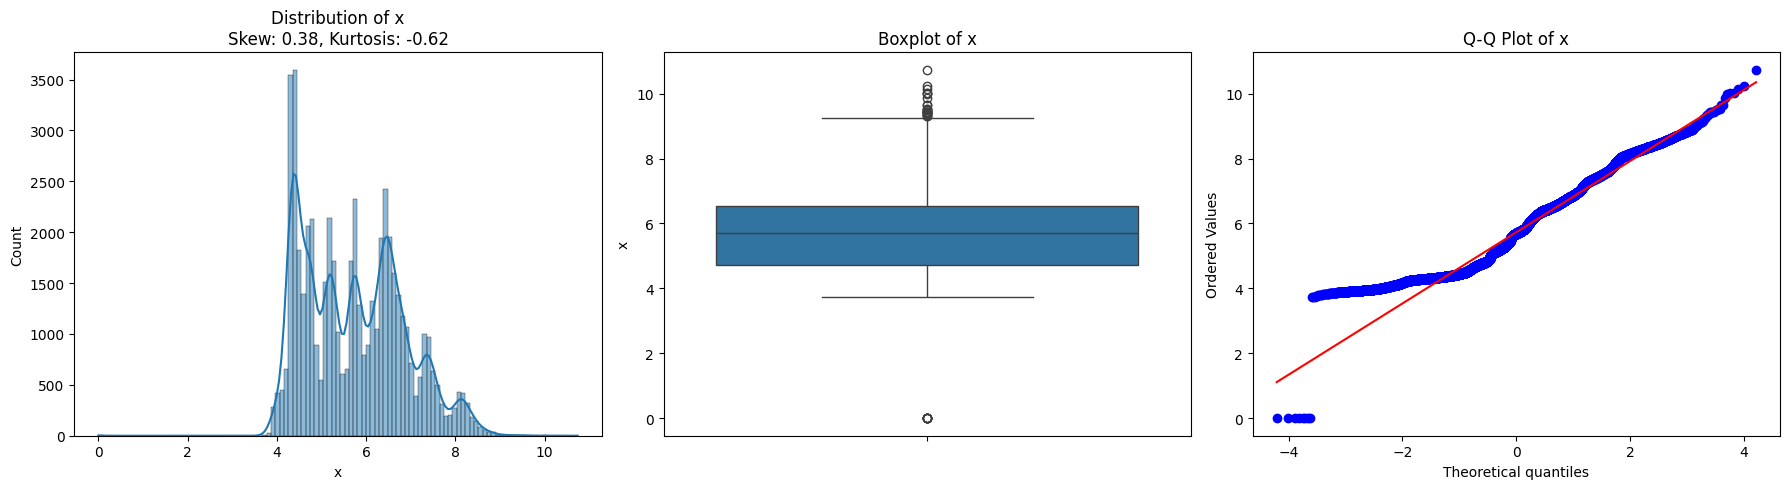

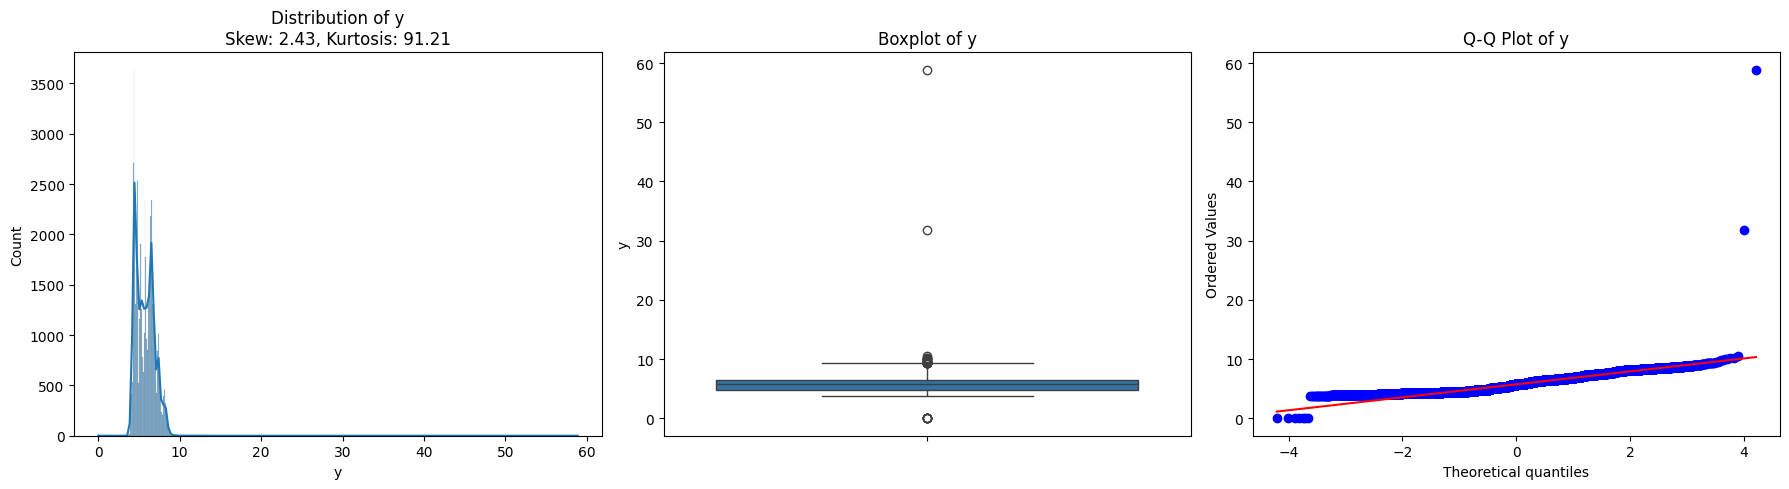

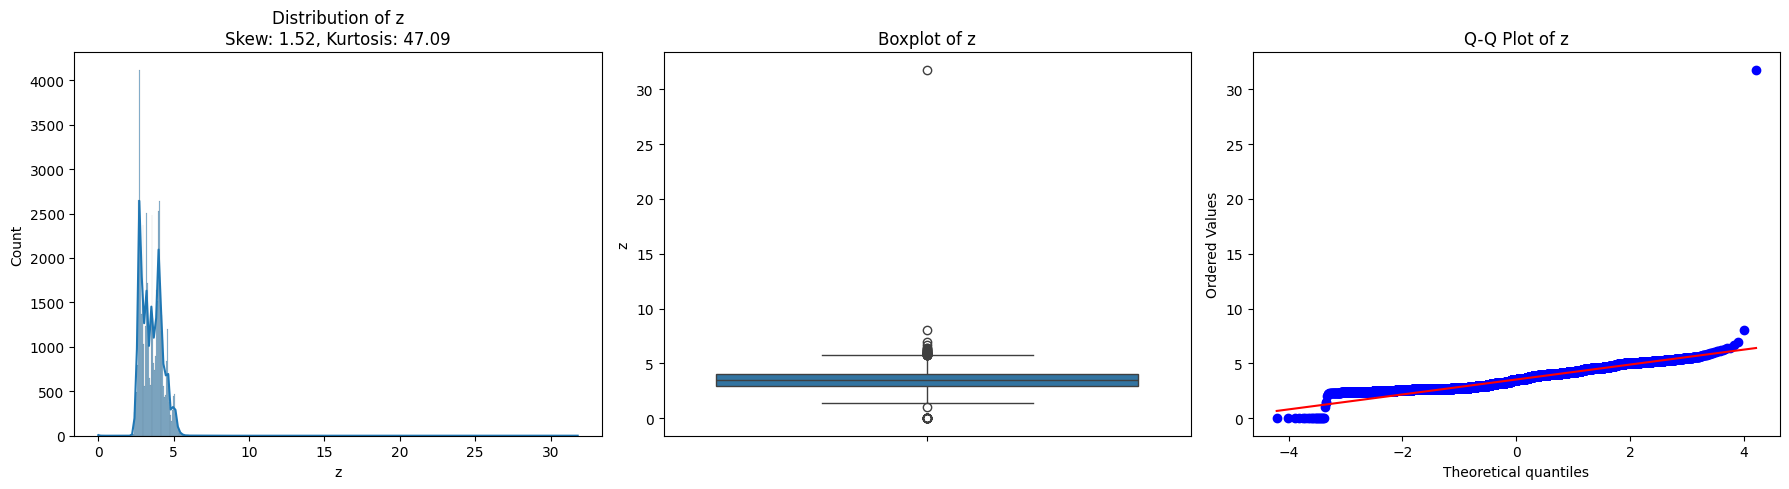

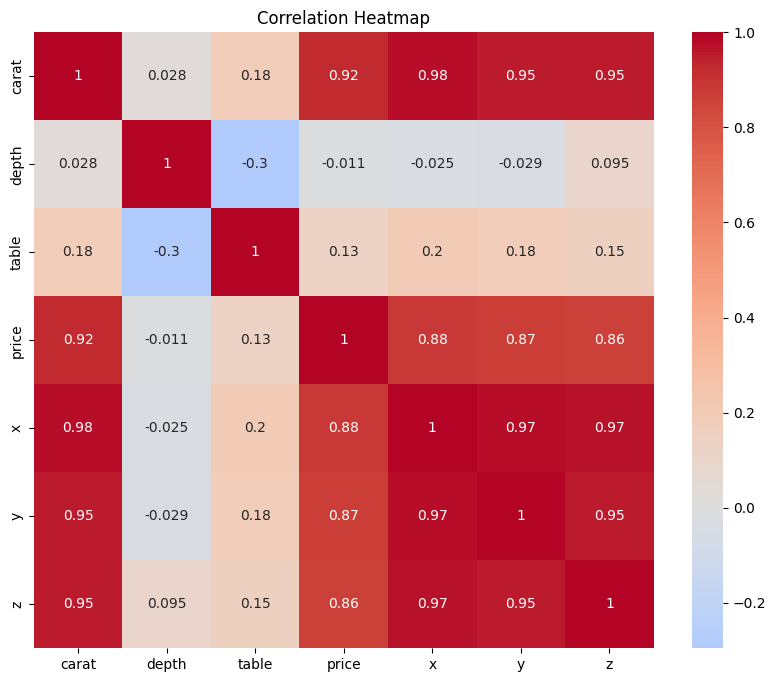

DATA PROFILE SUMMARY

Dataset Shape: (53940, 10)
Total Missing Values: 0
Duplicate Rows: 146

Data Types:
  float64: 6
  category: 1
  category: 1
  category: 1
  int64: 1

Numeric Columns Analysis:

Column: carat
Skewness: 1.12
Kurtosis: 1.26
Normality (Shapiro-Wilk p-value): 0.0000

Outliers Detected:
  IQR: 1889
  ZSCORE: 439
  ISOLATION_FOREST: 2688
  LOF: 354

Column: depth
Skewness: -0.08
Kurtosis: 5.74
Normality (Shapiro-Wilk p-value): 0.0000

Outliers Detected:
  IQR: 2545
  ZSCORE: 685
  ISOLATION_FOREST: 2646
  LOF: 302

Column: table
Skewness: 0.80
Kurtosis: 2.80
Normality (Shapiro-Wilk p-value): 0.0000

Outliers Detected:
  IQR: 605
  ZSCORE: 336
  ISOLATION_FOREST: 2021
  LOF: 432

Column: price
Skewness: 1.62
Kurtosis: 2.18
Normality (Shapiro-Wilk p-value): 0.0000

Outliers Detected:
  IQR: 3540
  ZSCORE: 1206
  ISOLATION_FOREST: 2696
  LOF: 2663

Column: x
Skewness: 0.38
Kurtosis: -0.62
Normality (Shapiro-Wilk p-value): 0.0000

Outliers Detected:
  IQR: 32
  ZSCORE: 43
 

In [1]:
# Question: Advanced Data Profiling and Outlier Detection
# Description: Perform detailed data profiling including outlier detection for numeric columns.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings('ignore')

def advanced_data_profiling(df, numeric_cols=None):
    """
    Perform comprehensive data profiling with outlier detection for numeric columns.
    
    Parameters:
        df (pd.DataFrame): Input dataframe
        numeric_cols (list): List of numeric columns to analyze (default: all numeric)
    
    Returns:
        dict: Dictionary containing profiling results and visualizations
    """
    
    # Initialize results dictionary
    profile_results = {
        'overview': {},
        'numeric_stats': {},
        'outliers': {}
    }
    
    # 1. Dataset Overview
    profile_results['overview']['shape'] = df.shape
    profile_results['overview']['missing_values'] = df.isnull().sum().sum()
    profile_results['overview']['duplicates'] = df.duplicated().sum()
    profile_results['overview']['dtypes'] = df.dtypes.value_counts().to_dict()
    
    # 2. Numeric Columns Analysis
    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    for col in numeric_cols:
        col_stats = {}
        col_data = df[col].dropna()
        
        # Basic Statistics
        col_stats['describe'] = col_data.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])
        col_stats['skewness'] = col_data.skew()
        col_stats['kurtosis'] = col_data.kurtosis()
        
        # Normality Tests
        shapiro_test = stats.shapiro(col_data)
        col_stats['normality'] = {
            'shapiro_stat': shapiro_test[0],
            'shapiro_p': shapiro_test[1],
            'is_normal': shapiro_test[1] > 0.05
        }
        
        # Outlier Detection (Multiple Methods)
        outliers = {}
        
        # IQR Method
        q1 = col_data.quantile(0.25)
        q3 = col_data.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers['iqr'] = {
            'count': ((col_data < lower_bound) | (col_data > upper_bound)).sum(),
            'thresholds': {'lower': lower_bound, 'upper': upper_bound}
        }
        
        # Z-score Method
        z_scores = np.abs(stats.zscore(col_data))
        outliers['zscore'] = {
            'count': (z_scores > 3).sum(),
            'threshold': 3
        }
        
        # Isolation Forest
        clf = IsolationForest(contamination=0.05, random_state=42)
        preds = clf.fit_predict(col_data.values.reshape(-1, 1))
        outliers['isolation_forest'] = {
            'count': (preds == -1).sum()
        }
        
        # Local Outlier Factor
        lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
        preds = lof.fit_predict(col_data.values.reshape(-1, 1))
        outliers['lof'] = {
            'count': (preds == -1).sum()
        }
        
        col_stats['outliers'] = outliers
        profile_results['numeric_stats'][col] = col_stats
        
        # Visualization
        plt.figure(figsize=(18, 5))
        
        # Histogram with KDE
        plt.subplot(1, 3, 1)
        sns.histplot(col_data, kde=True)
        plt.title(f'Distribution of {col}\nSkew: {col_stats["skewness"]:.2f}, Kurtosis: {col_stats["kurtosis"]:.2f}')
        
        # Boxplot
        plt.subplot(1, 3, 2)
        sns.boxplot(y=col_data)
        plt.title(f'Boxplot of {col}')
        
        # QQ Plot
        plt.subplot(1, 3, 3)
        stats.probplot(col_data, dist="norm", plot=plt)
        plt.title(f'Q-Q Plot of {col}')
        
        plt.tight_layout()
        plt.show()
    
    # 3. Correlation Analysis (if multiple numeric columns)
    if len(numeric_cols) > 1:
        plt.figure(figsize=(10, 8))
        corr = df[numeric_cols].corr()
        sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
        plt.title('Correlation Heatmap')
        plt.show()
        profile_results['correlation'] = corr
    
    return profile_results

# Example Usage
if __name__ == "__main__":
    # Load sample dataset
    diamonds = sns.load_dataset('diamonds')
    
    # Select numeric columns
    numeric_cols = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
    
    # Run advanced profiling
    results = advanced_data_profiling(diamonds, numeric_cols)
    
    # Print summary results
    print("="*50)
    print("DATA PROFILE SUMMARY")
    print("="*50)
    print(f"\nDataset Shape: {results['overview']['shape']}")
    print(f"Total Missing Values: {results['overview']['missing_values']}")
    print(f"Duplicate Rows: {results['overview']['duplicates']}")
    print("\nData Types:")
    for dtype, count in results['overview']['dtypes'].items():
        print(f"  {dtype}: {count}")
    
    print("\nNumeric Columns Analysis:")
    for col, stats in results['numeric_stats'].items():
        print(f"\nColumn: {col}")
        print(f"Skewness: {stats['skewness']:.2f}")
        print(f"Kurtosis: {stats['kurtosis']:.2f}")
        print(f"Normality (Shapiro-Wilk p-value): {stats['normality']['shapiro_p']:.4f}")
        print("\nOutliers Detected:")
        for method, vals in stats['outliers'].items():
            print(f"  {method.upper()}: {vals['count']}")


